In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import gammainc as gamma
from scipy.special import iv as I
from scipy.special import factorial
from scipy.signal import unit_impulse as delta
e = np.exp(1)

In [11]:
kap = 0.01 # trapping
k1 = 0.1 # rest
k2 = 1.0 # motion
v = 1.0
    
def p(x,t,kap=kap,k1=k1,k2=k2,v=v):
    t = t.astype('float128')
    x = x.astype('float64')
    kp = k1+k2
    tmxv = t-x/v
    the = np.heaviside(tmxv,1)
    tmxv[tmxv<=0]=np.nan
    a = e**(-(kap+k1)*tmxv-k2*x/v)
    b = 1/v*np.sqrt(k1*k2*x/v/tmxv)*the*I(1,2*np.sqrt(k1*k2*x/v*tmxv))
    c = k2/v*the*I(0,2*np.sqrt(k1*k2*x/v*tmxv))
    
    n = 50 # number of terms to keep in Q
    j = np.arange(n).reshape(-1,1).astype('float64')
    d = kap*k2/v/(kap+k1)*the*e**(-k2*x/v)
    Q = ((k1*k2*x/v/(kap+k1))**j/factorial(j)**2)*gamma(j+1,(kap+k1)*tmxv)
    return a*(b+c)+d*np.nansum(Q,0)

    

nan residual
nan residual
0.0
0.03196393060335379 residual
0.03196393060335379 residual
0.9663819350962065
0.002043385719232034 residual
0.002043385719232034 residual
0.854378348701547
nan residual
nan residual
0.0
0.0410424993119494 residual
0.0410424993119494 residual
1.0002049422300578
0.0033689734995427344 residual
0.0033689734995427344 residual
1.0000167875833101


Text(0.5, 1.0, 'Diffusion of probability')

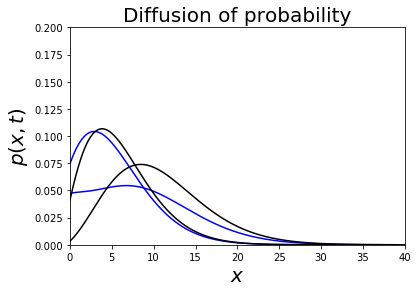

In [12]:
x = np.linspace(0,100,10000)
dx = x[1]-x[0]
t = np.linspace(0,50,3)
kap = 0.01 # trapping
k1 = 0.1 # rest
k2 = 1.0 # motion
v = 2.0
for tt in t:
    plt.plot(x,p(x,tt,kap=kap,k1=k1,k2=k2,v=v),color='blue')
    print(np.nansum(p(x,tt,kap=kap,k1=k1,k2=k2,v=v))*dx)
    
kap = 0.0 # trapping
k1 = 0.1 # rest
k2 = 1.0 # motion
v = 2.0
for tt in t:
    plt.plot(x,p(x,tt,kap=kap,k1=k1,k2=k2,v=v),color='black')
    print(np.nansum(p(x,tt,kap=kap,k1=k1,k2=k2,v=v))*dx)
    
plt.xlim(0,40)
plt.ylim(0,0.2)
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$p(x,t)$',fontsize=20)
plt.title('Diffusion of probability',fontsize=20)

In [234]:
t = np.linspace(0,500,1000)
x = np.linspace(0,500,1000)
kap = 0.05 # trapping
k1 = 0.1 # rest
k2 = 1.0 # motion
v = 2.0
# calculate the variance
P = []
for tt in t:
    P.append(p(x,tt,kap=kap,k1=k1,k2=k2,v=v))

In [235]:
means = [np.nansum(x*p) for p in P]
var = [np.nansum((x*p-m)**2) for m,p in zip(means,P)]

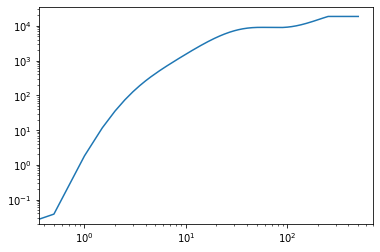

In [236]:
plt.loglog(t,var)